In [2]:
import os
import uuid
import shutil
#import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
#from pylatex.section import Chapter, Subsection
#from pylatex import Document, Section, Figure, NoEscape, Command

%run pipeline.ipynb

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_columns = None

In [4]:
mylc=get_lc_string('TIC-59129133-43-SPOC-120')
mylc2=get_lc_string('TIC-59129133-5-FFI-30min')
mylc3=get_lc_string('EPIC-246676629-13-EVEREST-1800')

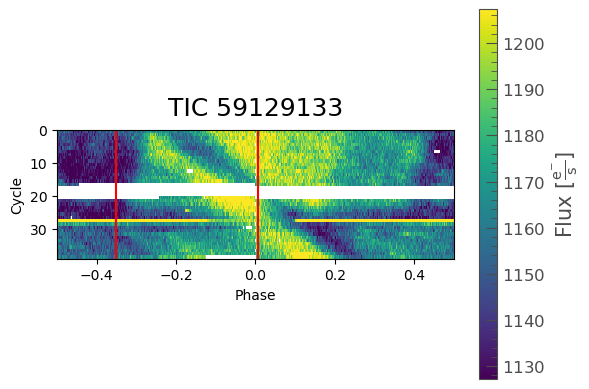

In [5]:
river_plot(mylc)

In [6]:
# def subgraph_rp(lc, epoch_time=None, period=None, ax=None, normalize=True):
#     fig = None
    
#     if period == None:
#         period = lc.to_periodogram(maximum_period=5).period_at_max_power
#     if epoch_time == None:
#         epoch_time = lc.time[0]
#     if normalize:
#         lc=lc.normalize()

#     lc = lc.fold(period, epoch_time=epoch_time)    
#     blc = lc.bin(u.Quantity(period/200, u.d))
#     blc.sort("flux")

#     min = blc[0][0].value/lc.period.value
#     max = blc[-1][0].value/lc.period.value

#     if ax == None:
#         fig, ax = plt.subplots()
    
#     lc.plot_river(ax=ax)
    
#     ax.axvline(min, 0, 1, color="red")
#     ax.axvline(max, 0, 1, color="red")
    
#     if fig != None:
#         return fig

In [7]:
#exact version from the documentation
def plot_river(
        self,
        period,
        epoch_time=None,
        ax=None,
        bin_points=1,
        minimum_phase=-0.5,
        maximum_phase=0.5,
        method="mean",
        **kwargs,
    ) -> matplotlib.axes.Axes:
        """Plot the light curve as a river plot.

        A river plot uses colors to represent the light curve values in
        chronological order, relative to the period of an interesting signal.
        Each row in the plot represents a full period cycle, and each column
        represents a fixed phase.  This type of plot is often used to visualize
        Transit Timing Variations (TTVs) in the light curves of exoplanets, but
        it can be used to visualize periodic signals of any origin.

        All extra keywords supplied are passed on to Matplotlib's
        `~matplotlib.pyplot.pcolormesh` function.

        Parameters
        ----------
        ax : `~matplotlib.axes.Axes`
            The matplotlib axes object.
        period: float
            Period at which to fold the light curve
        epoch_time : float
            Phase mid point for plotting. Defaults to the first time value.
        bin_points : int
            How many points should be in each bin.
        minimum_phase : float
            The minimum phase to plot.
        maximum_phase : float
            The maximum phase to plot.
        method : str
            The river method. Choose from `'mean'` or `'median'` or `'sigma'`.
            If `'mean'` or `'median'`, the plot will display the average value in each bin.
            If `'sigma'`, the plot will display the average in the bin divided by
            the error in each bin, in order to show the data in terms of standard
            deviation.
        kwargs : dict
            Dictionary of arguments to be passed on to Matplotlib's
            `~matplotlib.pyplot.pcolormesh` function.

        Returns
        -------
        ax : `~matplotlib.axes.Axes`
            The matplotlib axes object.
        """
        if hasattr(self, "time_original"):  # folded light curve
            time = self.time_original
        else:
            time = self.time

        # epoch_time defaults to the first time value
        if epoch_time is None:
            epoch_time = time[0]

        # Lightkurve v1.x assumed that `period` was given in days if no unit
        # was specified.  We maintain this behavior for backwards-compatibility.
        if period is not None and not isinstance(period, Quantity):
            period *= u.day
        if epoch_time is not None and not isinstance(epoch_time, (Time, Quantity)):
            epoch_time = Time(epoch_time, format=time.format, scale=time.scale)

        method = validate_method(method, supported_methods=["mean", "median", "sigma"])
        if (bin_points == 1) and (method in ["mean", "median"]):
            bin_func = lambda y, e: (y[0], e[0])
        elif (bin_points == 1) and (method in ["sigma"]):
            bin_func = lambda y, e: ((y[0] - 1) / e[0], np.nan)
        elif method == "mean":
            bin_func = lambda y, e: (np.nanmean(y), np.nansum(e**2) ** 0.5 / len(e))
        elif method == "median":
            bin_func = lambda y, e: (np.nanmedian(y), np.nansum(e**2) ** 0.5 / len(e))
        elif method == "sigma":
            bin_func = lambda y, e: (
                (np.nanmean(y) - 1) / (np.nansum(e**2) ** 0.5 / len(e)),
                np.nan,
            )

        s = np.argsort(time.value)
        x, y, e = time.value[s], self.flux[s], self.flux_err[s]
        med = np.nanmedian(self.flux)
        e /= med
        y /= med

        # Here `ph` is the phase of each time point x
        # cyc is the number of cycles that have occurred at each time point x
        # since the phase 0 before x[0]
        n = int(
            period.value
            / np.nanmedian(np.diff(x))
            * (maximum_phase - minimum_phase)
            / bin_points
        )
        if n == 1:
            bin_points = int(maximum_phase - minimum_phase) / (
                2 / int(period.value / np.nanmedian(np.diff(x)))
            )
            warnings.warn(
                "`bin_points` is too high to plot a phase curve, resetting to {}".format(
                    bin_points
                ),
                LightkurveWarning,
            )
            n = 2
        ph = x / period.value % 1
        cyc = np.asarray((x - x % period.value) / period.value, int)
        cyc -= np.min(cyc)

        phase = (epoch_time.value % period.value) / period.value
        ph = ((x - (phase * period.value)) / period.value) % 1
        cyc = np.asarray(
            (x - ((x - phase * period.value) % period.value)) / period.value, int
        )
        cyc -= np.min(cyc)
        ph[ph > 0.5] -= 1

        ar = np.empty((n, np.max(cyc) + 1))
        ar[:] = np.nan
        bs = np.linspace(minimum_phase, maximum_phase, n + 1)
        cycs = np.arange(0, np.max(cyc) + 2)

        ph_masks = [(ph > bs[jdx]) & (ph <= bs[jdx + 1]) for jdx in range(n)]
        qual_mask = np.isfinite(y)
        for cyc1 in np.unique(cyc):
            cyc_mask = cyc == cyc1
            if not np.any(cyc_mask):
                continue
            for jdx, ph_mask in enumerate(ph_masks):
                if not np.any(cyc_mask & ph_mask & qual_mask):
                    ar[jdx, cyc1] = np.nan
                else:
                    ar[jdx, cyc1] = bin_func(
                        y[cyc_mask & ph_mask], e[cyc_mask & ph_mask]
                    )[0]

        # If the method is average we need to denormalize the plot
        if method in ["mean", "median"]:
            median = np.nanmedian(self.flux.value)
            if hasattr(median, "mask"):
                median = median.filled(np.nan)
            ar *= median

        d = np.max(
            [
                np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 5)),
                np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 95)),
            ]
        )
        vmin = kwargs.pop("vmin", np.nanmedian(ar) - d)
        vmax = kwargs.pop("vmax", np.nanmedian(ar) + d)
        if method in ["mean", "median"]:
            cmap = kwargs.pop("cmap", "viridis")
        elif method == "sigma":
            cmap = kwargs.pop("cmap", "coolwarm")

        with plt.style.context(MPLSTYLE):
            if ax is None:
                _, ax = plt.subplots(figsize=(12, cyc.max() * 0.1))

            im = ax.pcolormesh(
                bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs
            )
            cbar = plt.colorbar(im, ax=ax)
            if method in ["mean", "median"]:
                unit = "[Normalized Flux]"
                if self.flux.unit is not None:
                    if self.flux.unit != u.dimensionless_unscaled:
                        unit = "[{}]".format(self.flux.unit.to_string("latex"))
                if bin_points == 1:
                    cbar.set_label("Flux {}".format(unit))
                else:
                    cbar.set_label("Average Flux in Bin {}".format(unit))
            elif method == "sigma":
                if bin_points == 1:
                    cbar.set_label(
                        "Flux in units of Standard Deviation "
                        r"$(f - \overline{f})/(\sigma_f)$"
                    )
                else:
                    cbar.set_label(
                        "Average Flux in Bin in units of Standard Deviation "
                        r"$(f - \overline{f})/(\sigma_f)$"
                    )

            ax.set_xlabel("Phase")
            ax.set_ylabel("Cycle")
            ax.set_ylim(cyc.max(), 0)
            ax.set_title(self.meta.get("LABEL"))
            a = cyc.max() * 0.1 / 12.0
            b = (cyc.max() - cyc.min()) / (bs.max() - bs.min())
            ax.set_aspect(a / b)
        return ax

In [8]:
myperiod=mylc.to_periodogram(maximum_period=5).period_at_max_power

In [9]:
u.Quantity(myperiod,u.s)

<Quantity 54169.81060915 s>

In [10]:
u.Quantity(myperiod/200,u.s)

<Quantity 270.84905305 s>

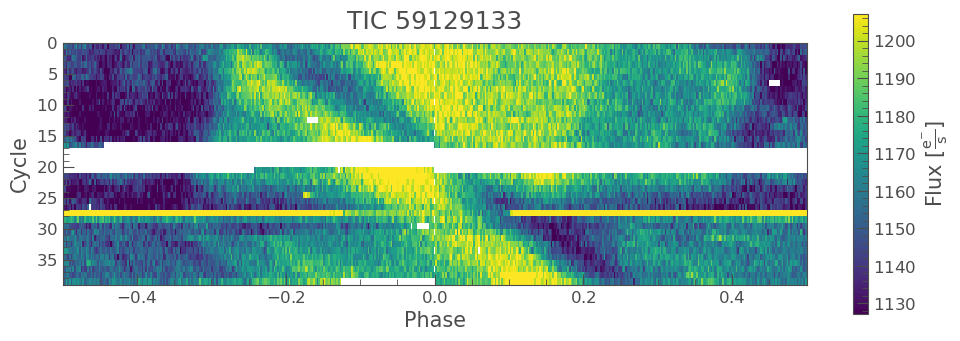

In [11]:
plt.close('all')
ax=mylc.plot_river(period=myperiod)
plt.show()

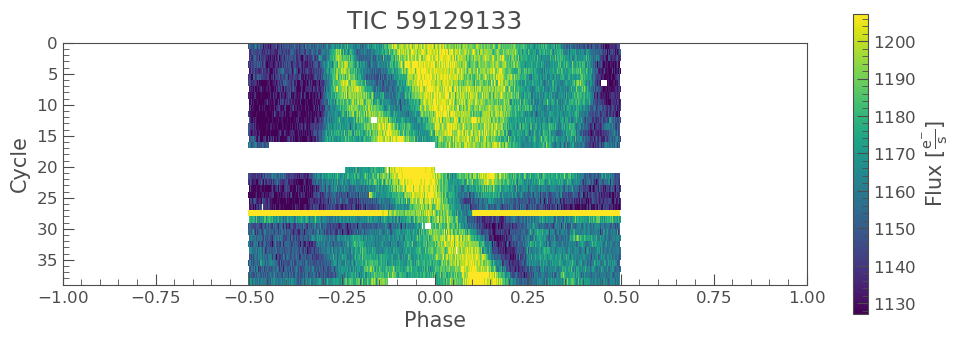

In [12]:
plt.close('all')
ax=mylc.plot_river(period=myperiod, minimum_phase=-1, maximum_phase=1)
plt.show()

In [13]:
# def subgraph_rp(
#         lc,
#         period=None,
#         epoch_time=None,
#         ax=None,
#         bin_points=1,
#         minimum_phase=-0.5,
#         maximum_phase=0.5,
#         method="mean",
#         normalize=True,
#         **kwargs,
#     ) -> matplotlib.axes.Axes:

#         fig = None
    
#         if hasattr(lc, "time_original"):  # folded light curve
#             time = lc.time_original
#         else:
#             time = lc.time

#         if period == None:
#             period = lc.to_periodogram(maximum_period=5).period_at_max_power
#         if epoch_time == None:
#             epoch_time = lc.time[0]
#         if normalize:
#             lc=lc.normalize()

#         foldedlc = lc.fold(period, epoch_time=epoch_time) 
#         blc = foldedlc.bin(u.Quantity(period/200, u.d))
#         blc.sort("flux")
#         min = blc[0][0].value/foldedlc.period.value
#         max = blc[-1][0].value/foldedlc.period.value

#         if (bin_points == 1) and (method in ["mean", "median"]):
#             bin_func = lambda y, e: (y[0], e[0])
#         elif method == "mean":
#             bin_func = lambda y, e: (np.nanmean(y), np.nansum(e**2) ** 0.5 / len(e))

#         s = np.argsort(time.value)
#         x, y, e = time.value[s], lc.flux[s], lc.flux_err[s]
#         med = np.nanmedian(lc.flux)
#         e /= med
#         y /= med

#         # Here `ph` is the phase of each time point x
#         # cyc is the number of cycles that have occurred at each time point x
#         # since the phase 0 before x[0]
#         n = int(
#             period.value
#             / np.nanmedian(np.diff(x))
#             * (maximum_phase - minimum_phase)
#             / bin_points
#         )
#         if n == 1:
#             bin_points = int(maximum_phase - minimum_phase) / (
#                 2 / int(period.value / np.nanmedian(np.diff(x)))
#             )
#             warnings.warn(
#                 "`bin_points` is too high to plot a phase curve, resetting to {}".format(
#                     bin_points
#                 ),
#                 LightkurveWarning,
#             )
#             n = 2
#         ph = x / period.value % 1
#         cyc = np.asarray((x - x % period.value) / period.value, int)
#         cyc -= np.min(cyc)

#         phase = (epoch_time.value % period.value) / period.value
#         ph = ((x - (phase * period.value)) / period.value) % 1
#         cyc = np.asarray(
#             (x - ((x - phase * period.value) % period.value)) / period.value, int
#         )
#         cyc -= np.min(cyc)
#         ph[ph > 0.5] -= 1

#         ar = np.empty((n, np.max(cyc) + 1))
#         ar[:] = np.nan
#         bs = np.linspace(minimum_phase, maximum_phase, n + 1)
#         cycs = np.arange(0, np.max(cyc) + 2)

#         ph_masks = [(ph > bs[jdx]) & (ph <= bs[jdx + 1]) for jdx in range(n)]
#         qual_mask = np.isfinite(y)
#         for cyc1 in np.unique(cyc):
#             cyc_mask = cyc == cyc1
#             if not np.any(cyc_mask):
#                 continue
#             for jdx, ph_mask in enumerate(ph_masks):
#                 if not np.any(cyc_mask & ph_mask & qual_mask):
#                     ar[jdx, cyc1] = np.nan
#                 else:
#                     ar[jdx, cyc1] = bin_func(
#                         y[cyc_mask & ph_mask], e[cyc_mask & ph_mask]
#                     )[0]

    
#         # If the method is average we need to denormalize the plot
#         if method in ["mean", "median"]:
#             median = np.nanmedian(lc.flux.value)
#             if hasattr(median, "mask"):
#                 median = median.filled(np.nan)
#             ar *= median

#         d = np.max(
#             [
#                 np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 5)),
#                 np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 95)),
#             ]
#         )
#         vmin = kwargs.pop("vmin", np.nanmedian(ar) - d)
#         vmax = kwargs.pop("vmax", np.nanmedian(ar) + d)
#         if method in ["mean", "median"]:
#             cmap = kwargs.pop("cmap", "viridis")

#         with plt.style.context("seaborn-v0_8-paper"):
#             if ax == None:
#                 fig, ax = plt.subplots(figsize=(12, cyc.max() * 0.1))
#             # if ax is None:
#             #     _, ax = plt.subplots(figsize=(12, cyc.max() * 0.1))

#             im = ax.pcolormesh(
#                 bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs
#             )
#             cbar = plt.colorbar(im, ax=ax)

#             ax.axvline(min, 0, 1, color="red")
#             ax.axvline(max, 0, 1, color="red")
            
#             if method in ["mean", "median"]:
#                 unit = "[Normalized Flux]"
#                 if lc.flux.unit is not None:
#                     if lc.flux.unit != u.dimensionless_unscaled:
#                         unit = "[{}]".format(lc.flux.unit.to_string("latex"))
#                 if bin_points == 1:
#                     cbar.set_label("Normalized Flux")
#                 else:
#                     cbar.set_label("Average Flux in Bin {}".format(unit))

#             ax.set_xlabel("Phase")
#             ax.set_ylabel("Cycle")
#             ax.set_ylim(cyc.max(), 0)
#             a = cyc.max() * 0.1 / 12.0
#             b = (cyc.max() - cyc.min()) / (bs.max() - bs.min())
#             ax.set_aspect(a / b)
            
#         if fig != None:
#             return fig

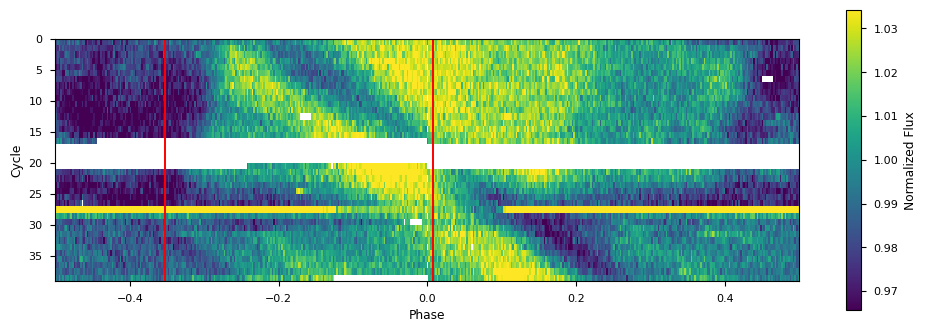

In [14]:
subgraph_rp(lc=mylc)

In [15]:
gaiatable=pd.read_csv('makingtable/cleanedgaiadata.csv')

In [16]:
gaiatable

pop_id  TIC  gaiadr3_source_id  epic_id  per disco_paper author  year  \
0          NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
1          NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
2          NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
3          NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
4          NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
...        ...  ...                ...      ...  ...         ...    ...   ...   
289023     NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
289024     NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
289025     NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
289026     NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   
289027     NaN  NaN                NaN      NaN  NaN         NaN    NaN   NaN   

                solution_id                   designation  \
0       1636148068921376768  Gaia DR3 4038033109587880320   
1       1636148068921376768  Gaia DR3 4038033113957334144   
2       1636148068921376768  Gaia DR3 4254096941279420544   
3       1636148068921376768  Gaia DR3 5908048646066350208   
4       1636148068921376768  Gaia DR3 5351935421597979008   
...                     ...                           ...   
289023  1636148068921376768  Gaia DR3 5908572941316155648   
289024  1636148068921376768  Gaia DR3 5907855132025151104   
289025  1636148068921376768  Gaia DR3 5908042358234161152   
289026  1636148068921376768  Gaia DR3 5908043457745804032   
289027  1636148068921376768  Gaia DR3 4038094269918933760   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0       4038033109587880320    1695533498     2016.0  272.828613  0.042580   
1       4038033113957334144    1138152201     2016.0  272.828713  0.078718   
2       4254096941279420544    1586931531     2016.0  283.959761  0.018378   
3       5908048646066350208     985378821     2016.0  223.643945  0.085274   
4       5351935421597979008     439886427     2016.0  156.823201  0.516770   
...                     ...           ...        ...         ...       ...   
289023  5908572941316155648    1802038697     2016.0  224.097598  0.067109   
289024  5907855132025151104    1119019317     2016.0  224.562244  0.028548   
289025  5908042358234161152      74557859     2016.0  223.221465  0.020047   
289026  5908043457745804032     250573889     2016.0  223.355824  0.020569   
289027  4038094269918933760     293924070     2016.0  274.326716  0.039537   

              dec  dec_error   parallax  parallax_error  parallax_over_error  \
0      -35.899347   0.036690  10.689331        0.048988           218.202090   
1      -35.899518   0.063410  10.414327        0.054373           191.535830   
2       -5.615253   0.016954  17.758853        0.021109           841.298600   
3      -44.369560   0.087488  10.348832        0.119198            86.820460   
4      -56.424426   0.543502  13.874530        0.637169            21.775288   
...           ...        ...        ...             ...                  ...   
289023 -42.854388   0.067343  12.028451        0.100307           119.916626   
289024 -44.574253   0.031233  13.033394        0.042538           306.396100   
289025 -44.585768   0.020970  11.903557        0.035290           337.308300   
289026 -44.538184   0.021762  18.114596        0.035420           511.422520   
289027 -36.513014   0.035367  15.743424        0.042816           367.700840   

                pm        pmra  pmra_error       pmdec  pmdec_error  \
0        50.451120  -31.437092    0.043802  -39.459151     0.035013   
1        51.095993  -24.290269    0.086224  -44.953122     0.066855   
2       200.911150    1.907500    0.022928 -200.902099     0.018906   
3        28.489578  -23.387472    0.126418  -16.269056     0.120313   
4       314.273470 -306.326061    0.561633  -70.2

In [17]:
ninety=np.percentile(mylc['flux'],90)
ten=np.percentile(mylc['flux'],10)
amplitude=ninety-ten

List of facts to include:
- TIC 
- GDR3
- EPIC
- Sector or campaign
- Cadence
- Discovery info
- Ra and dec 
- Absolute G, RP, bp
- G-RP
- RUWE
- Parallax
- Distance
- Age
- Group
- Amplitude - 90% flux to 10% flux value

In [19]:
# def subgraph_text(lc, infostring, gaiatable, ax=None):
#     #gaiatable must be a dataframe. load it in the multiplot fn
#     fig = None
    
#     parts=infostring.split("-")
#     id_type=parts[0]
#     starid=float(parts[1])
#     secorcamp=parts[2]
#     author=parts[3]
#     exptime=parts[4]
    
#     if ax == None:
#         fig, ax = plt.subplots()

#     if id_type=='TIC':
#         secorcampname='Sector'
#         gaiarow=gaiatable[gaiatable.TIC==starid]
#     elif id_type=='EPIC':
#         secorcampname='Campaign'
#         gaiarow=gaiatable[gaiatable.epic_id==starid]

#     ninety=np.percentile(lc['flux'],90)
#     ten=np.percentile(lc['flux'],10)
#     amplitude=ninety-ten
    
#     textstring=f'''{secorcampname} {secorcamp}
# TIC {int(gaiarow.TIC.values[0])}
# EPIC {int(gaiarow.epic_id.values[0])}
# GDR3 {int(gaiarow.gaiadr3_source_id.values[0])}
# Discovery Paper: {gaiarow.author.values[0]} {int(gaiarow.year.values[0])}
# Age:
# Stellar Group:
# RA: {round(gaiarow.ra.values[0],2)}, DEC: {round(gaiarow.dec.values[0],2)} degrees
# G: {round(gaiarow.g_absmag.values[0],2)}, RP: {round(gaiarow.rp_absmag.values[0],2)}, BP: {round(gaiarow.bp_absmag.values[0],2)} abs mag
# G-RP: {round(gaiarow.abs_g_rp.values[0],2)}
# RUWE: {round(gaiarow.ruwe.values[0],2)}
# Parallax: {round(gaiarow.parallax.values[0],2)} mas
# Distance: {round(gaiarow.distance.values[0],2)} pc
# Flux Amplitude (90th-10th): {amplitude:.2f}'''

#     ax.axis('off') #hide axes
#     ax.text(0.05, 0.97, textstring, transform=ax.transAxes, ha='left', va='top', fontsize=11)

#     if fig != None:
#         return fig

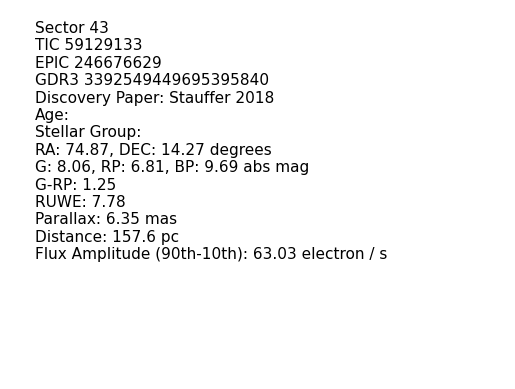

In [20]:
subgraph_text(mylc,'TIC-59129133-43-SPOC-120',gaiatable)

In [21]:
# def multiplot2(lc, infostring, gaiatable, period=None, bintime=None):
#     fig, axs = plt.subplot_mosaic([
#         ['A1', 'A2'],
#         ['A1', 'B2'],
#         ['C1', 'C2'],
#         ['D1', 'D2'],
#         ['E1', 'E1']
#     ], figsize=(16, 16))

#     if period==None:
#         period = lc.to_periodogram(maximum_period=5).period_at_max_power
#     if bintime==None:
#         bintime=u.Quantity(myperiod/200,u.s)
    
#     subgraph_phaselc(lc, ax=axs['A1'], period=period, bintime=bintime)
    
#     subgraph_pg(lc, ax = axs['C1'], period=period)

#     subgraph_2phaselc(lc, ax=axs['A2'], period=period, bintime=bintime)
#     subgraph_hphaselc(lc, ax=axs['B2'], period=period, bintime=bintime)

#     subgraph_rp(lc,ax=axs['C2'], period=period)

#     subgraph_CMD(infostring,gaiatable,ax=axs['D1'])

#     subgraph_text(lc, infostring,gaiatable,ax=axs['D2'])
    
#     subgraph_fulllc(lc, ax = axs['E1'])

#     return fig

In [22]:
fig=multiplot2(mylc, 'TIC-59129133-43-SPOC-120', gaiatable)
fig.savefig('TIC-59129133-43-SPOC-120.png')

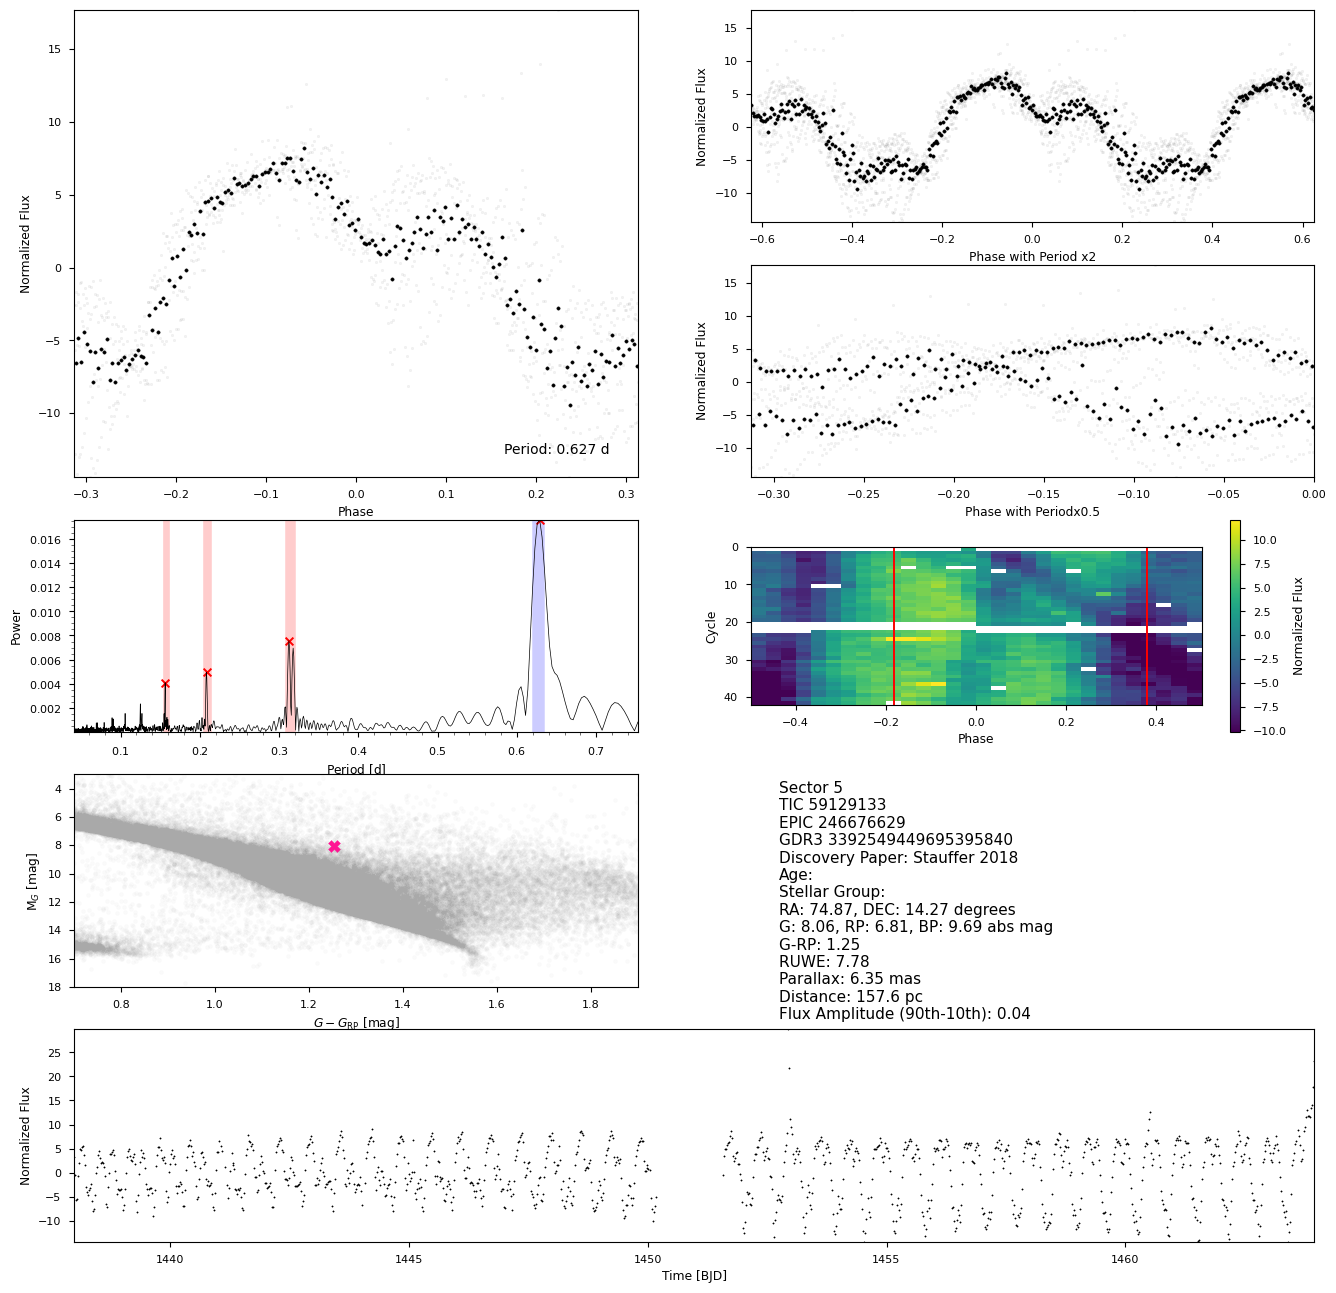

In [23]:
multiplot2(mylc2, 'TIC-59129133-5-FFI-30min', gaiatable)

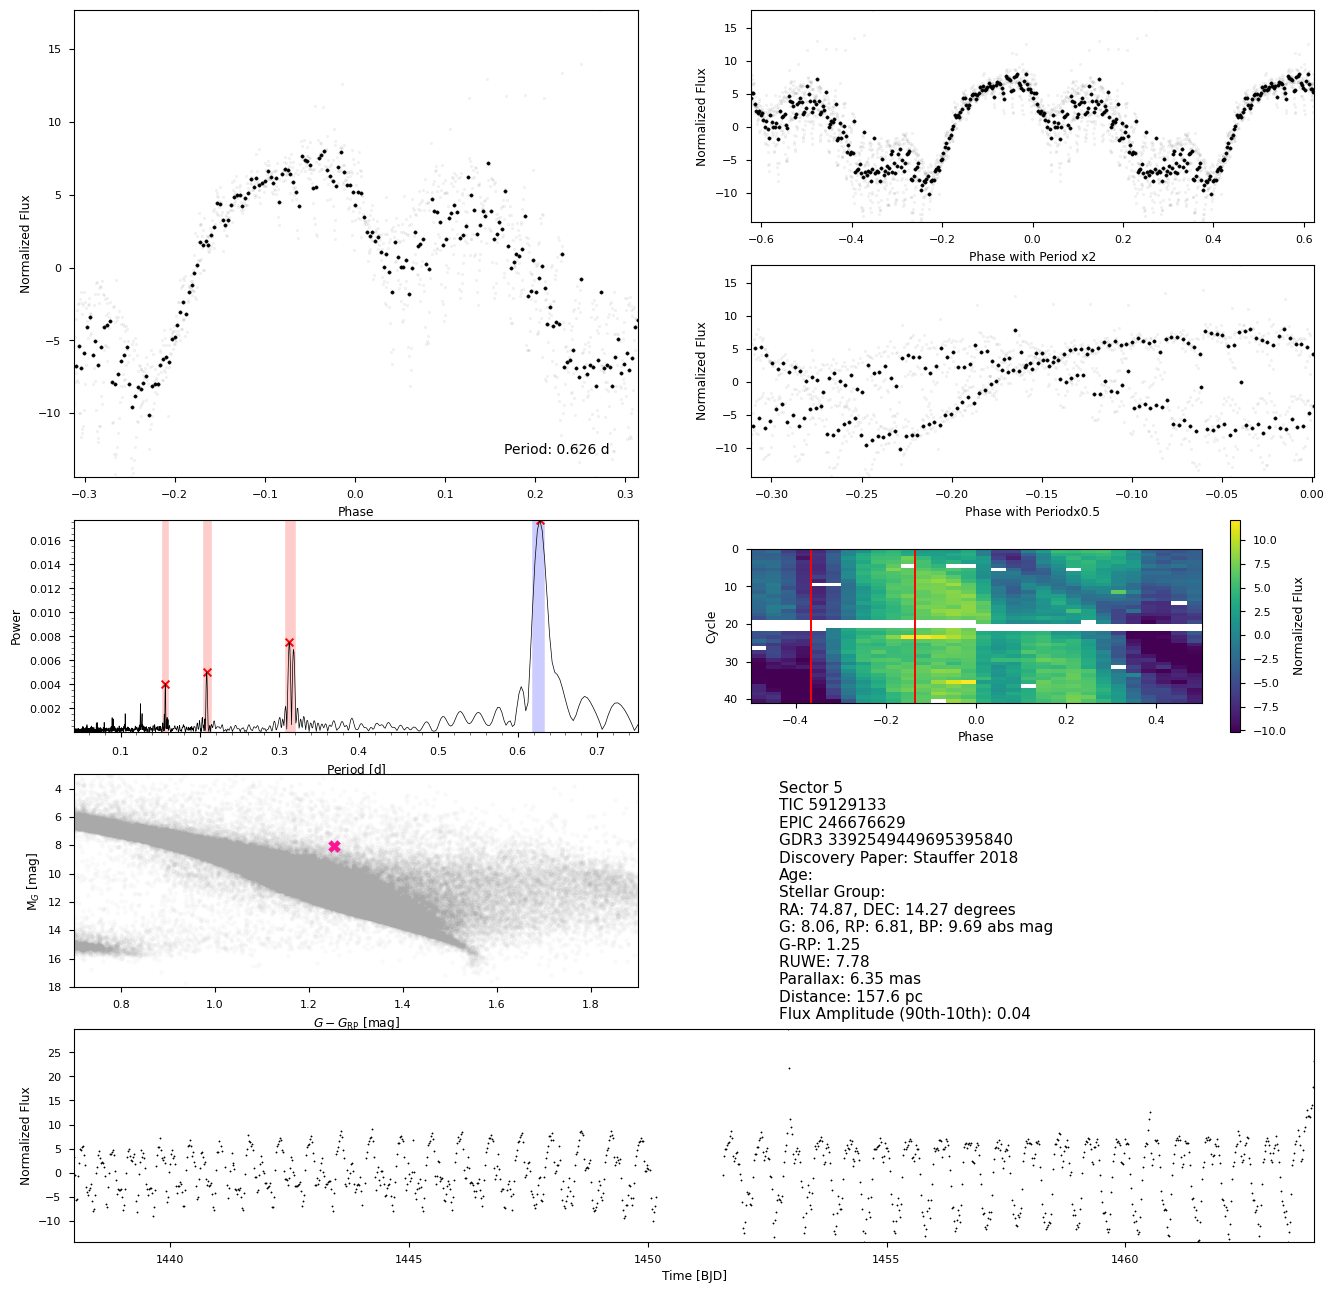

In [24]:
multiplot2(mylc2, 'TIC-59129133-5-FFI-30min', gaiatable,period=u.Quantity(0.626,u.d))

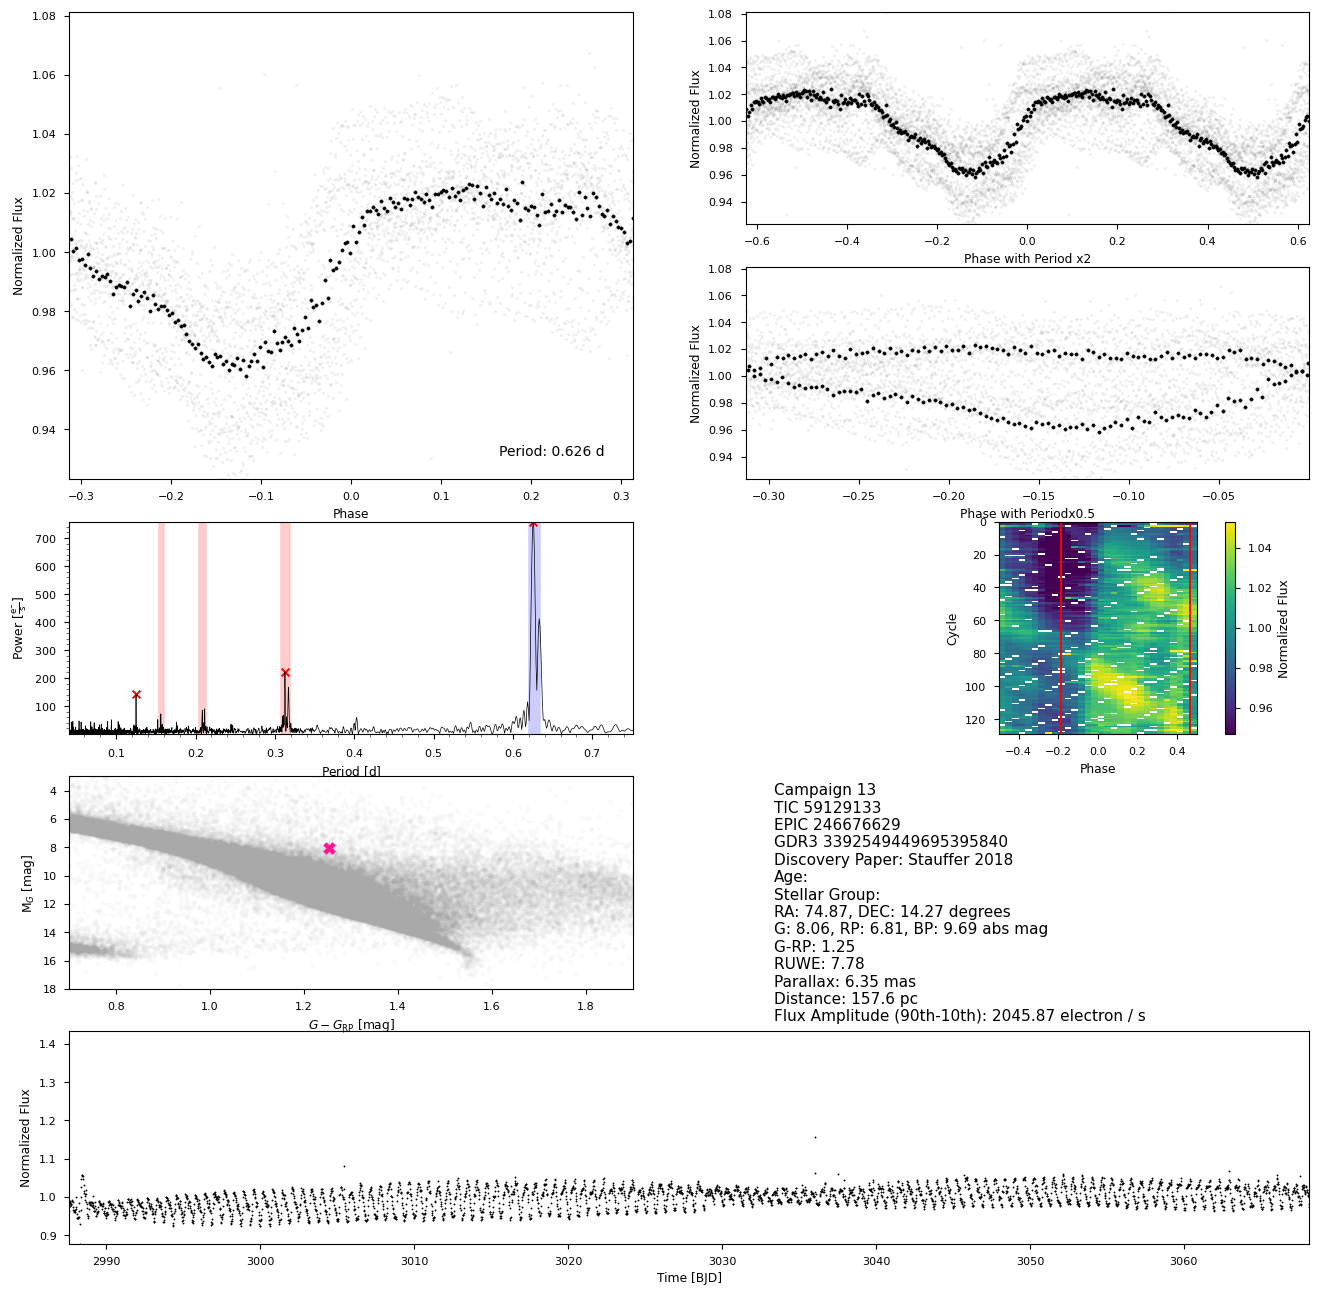

In [25]:
multiplot2(mylc3, 'EPIC-246676629-13-EVEREST-1800', gaiatable)

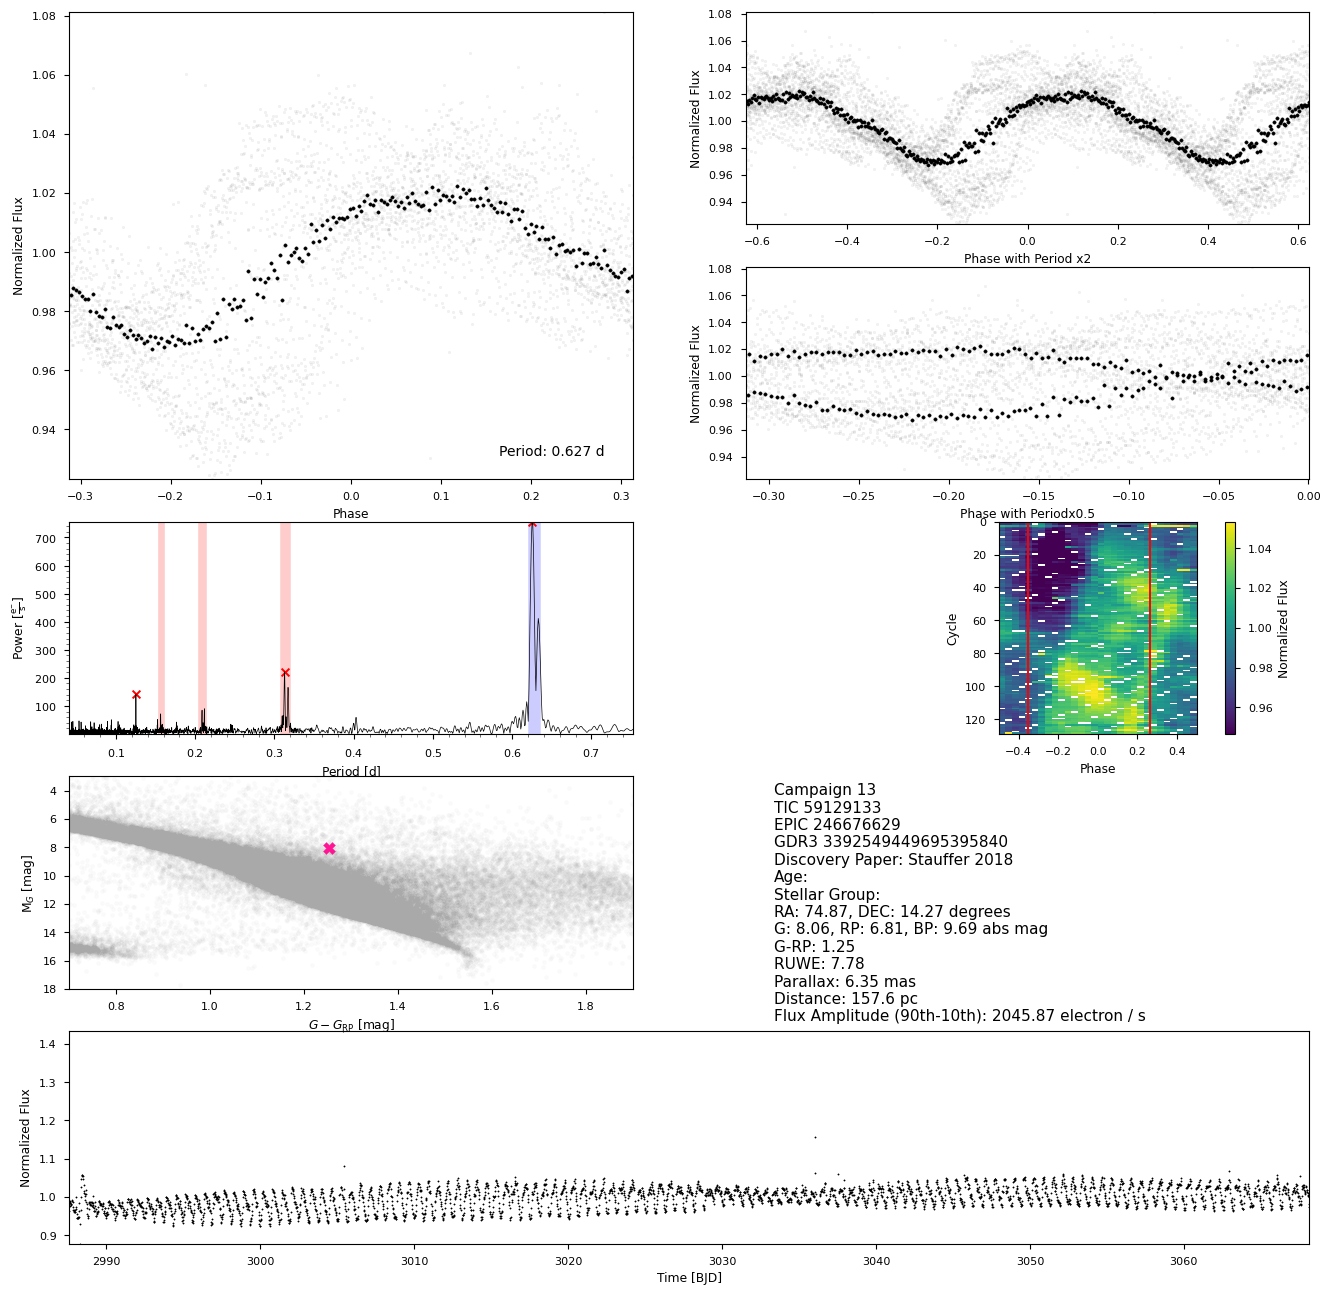

In [26]:
multiplot2(mylc3, 'EPIC-246676629-13-EVEREST-1800', gaiatable,period=u.Quantity(0.627,u.d))

In [27]:
#df=mylc3.to_pandas() # look for gaps of greater than 1 in cadenceno - found them

In [28]:
#df.reset_index(inplace=True)

In [29]:
#df['cadence_diff']=0

In [30]:
# for index, row in df.iterrows():
#     cadenceno=row['cadenceno']
#     nextcadenceno=df.at[index+1,'cadenceno']
#     difference=nextcadenceno-cadenceno
#     df.at[index,'cadence_diff']=difference

In [31]:
#df['cadence_diff'].value_counts()

In [32]:
mylc4=get_lc_string('EPIC-203692610-2-EVEREST-1800')
mylc5=get_lc_string('TIC-68131578-91-SPOC-120')

In [33]:
#multiplot2(mylc4, 'EPIC-203692610-2-EVEREST-1800', gaiatable,period=u.Quantity(1.821,u.d)) this one is horrible

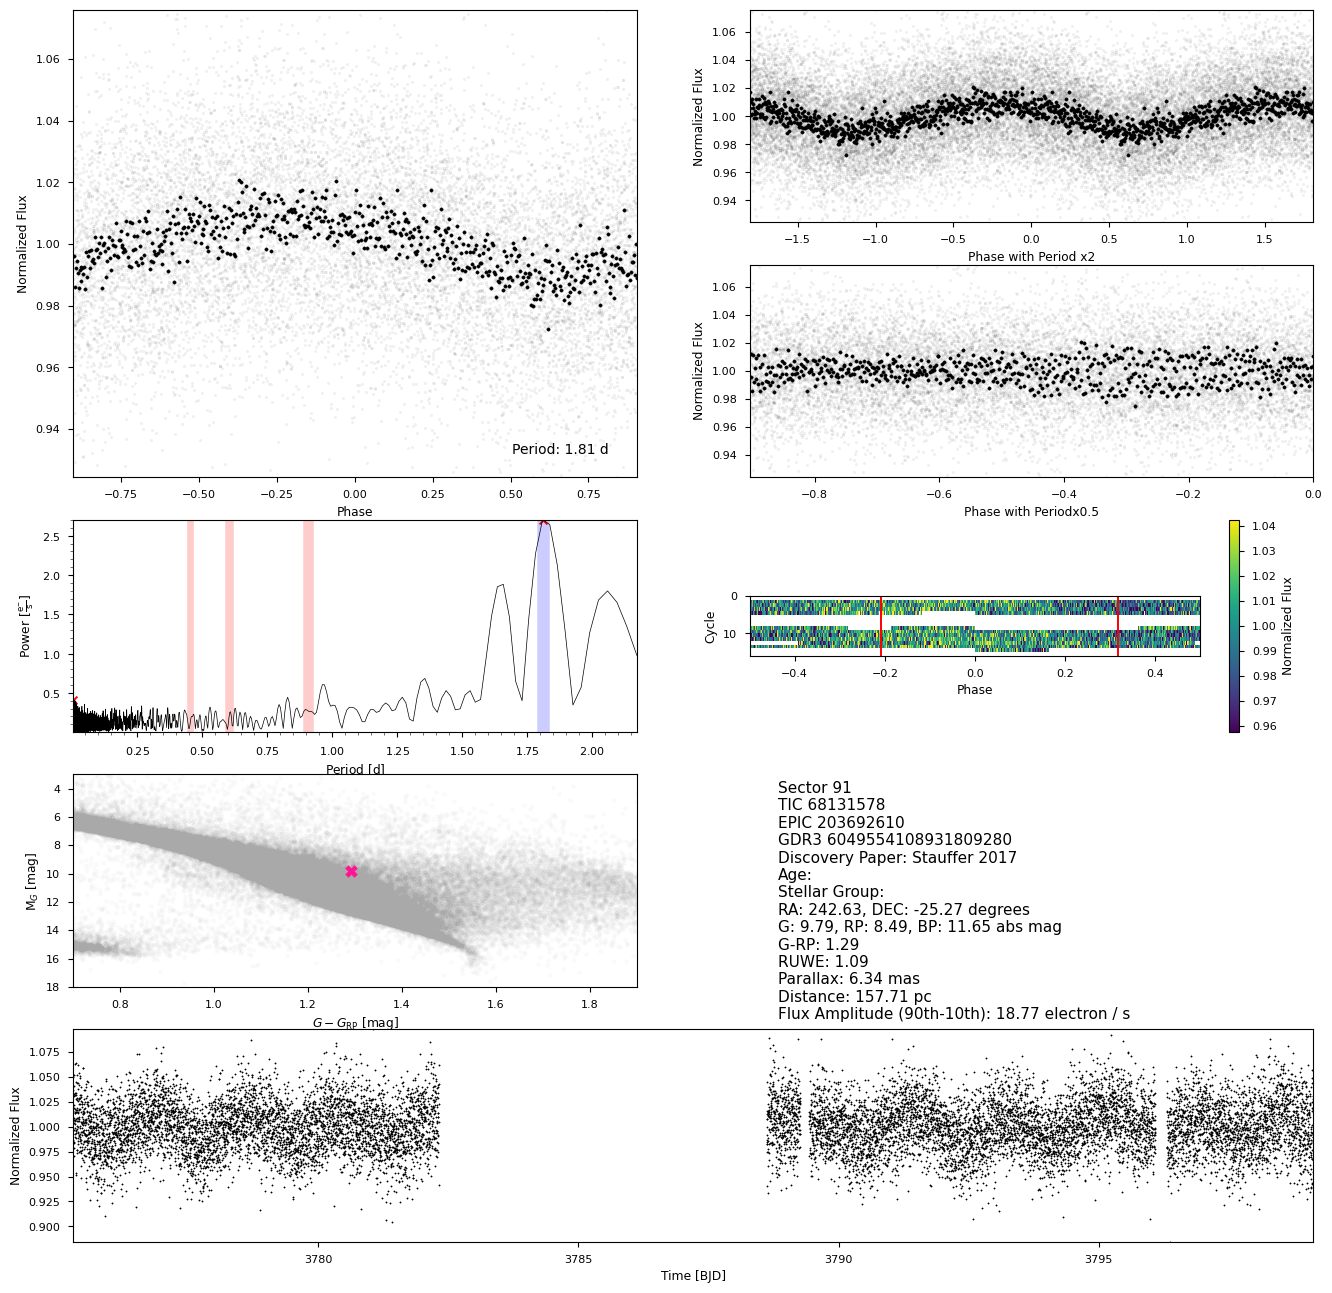

In [34]:
multiplot2(mylc5, 'TIC-68131578-91-SPOC-120', gaiatable)

In [35]:
mylc6=get_lc('EPIC',203692610 ,2, 'K2SFF', 1800)

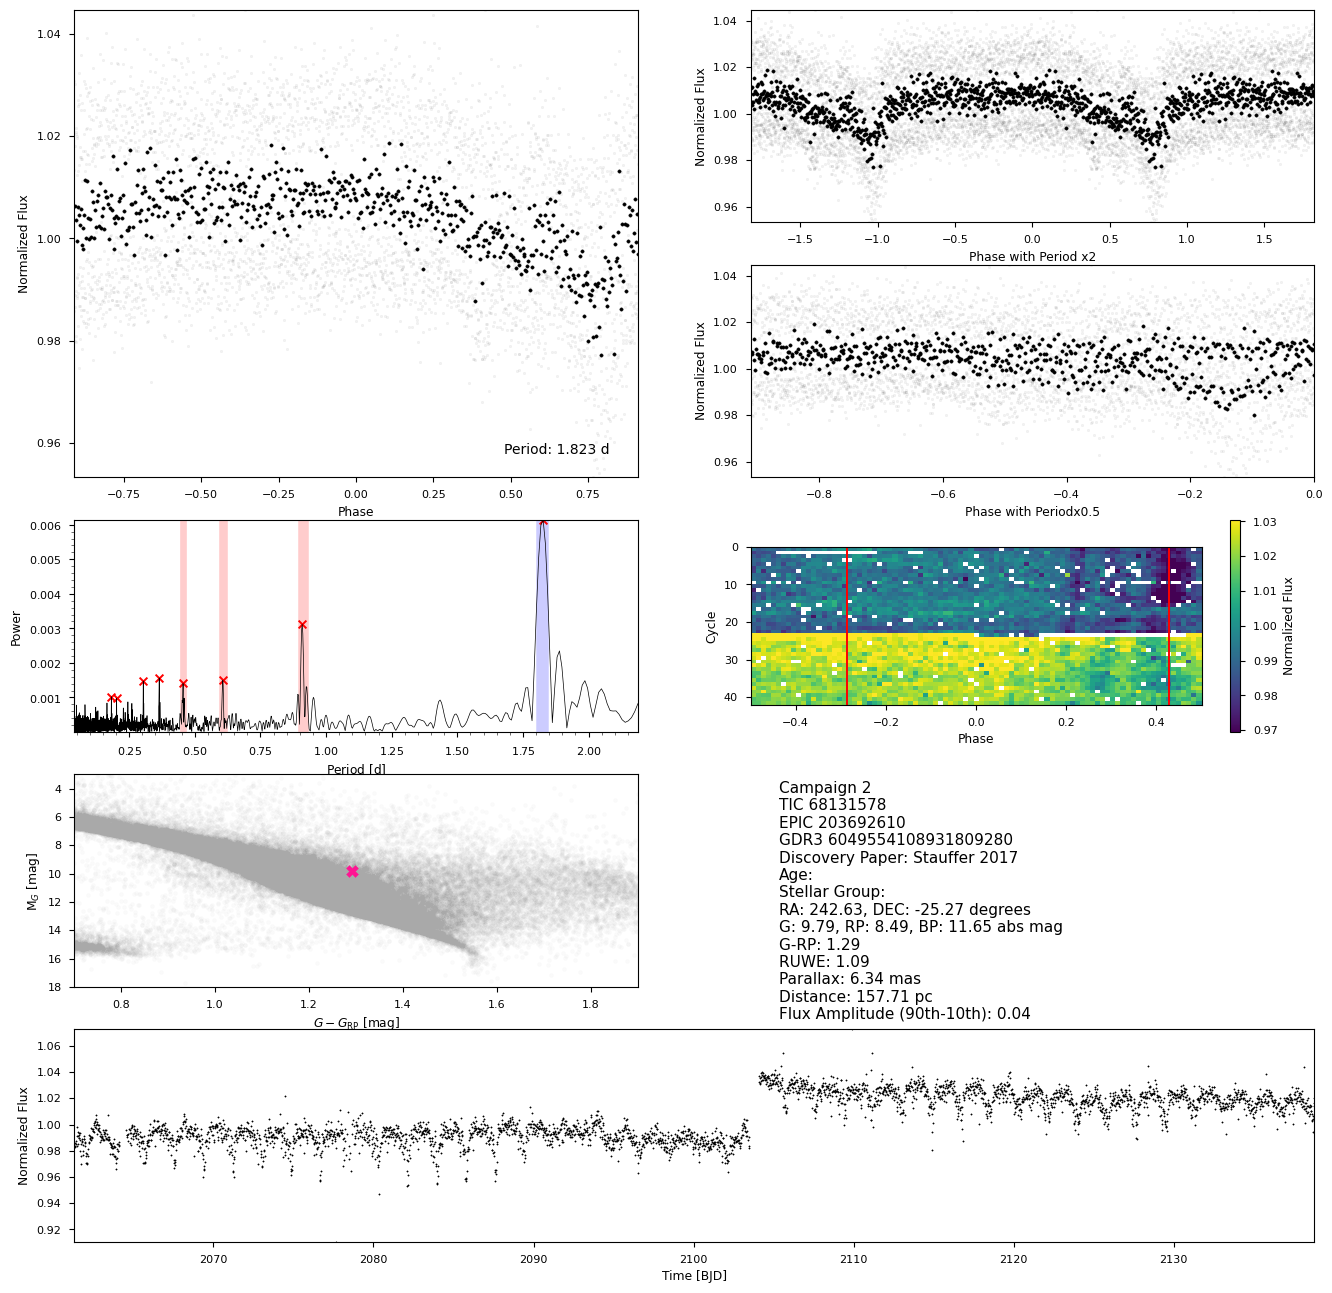

In [36]:
plt.close('all')
multiplot2(mylc6, 'EPIC-203692610-2-K2SFF-1800', gaiatable) #i think this one is normalized by default
plt.show()
#plt.savefig('EPIC-203692610-2-K2SFF-1800.png')

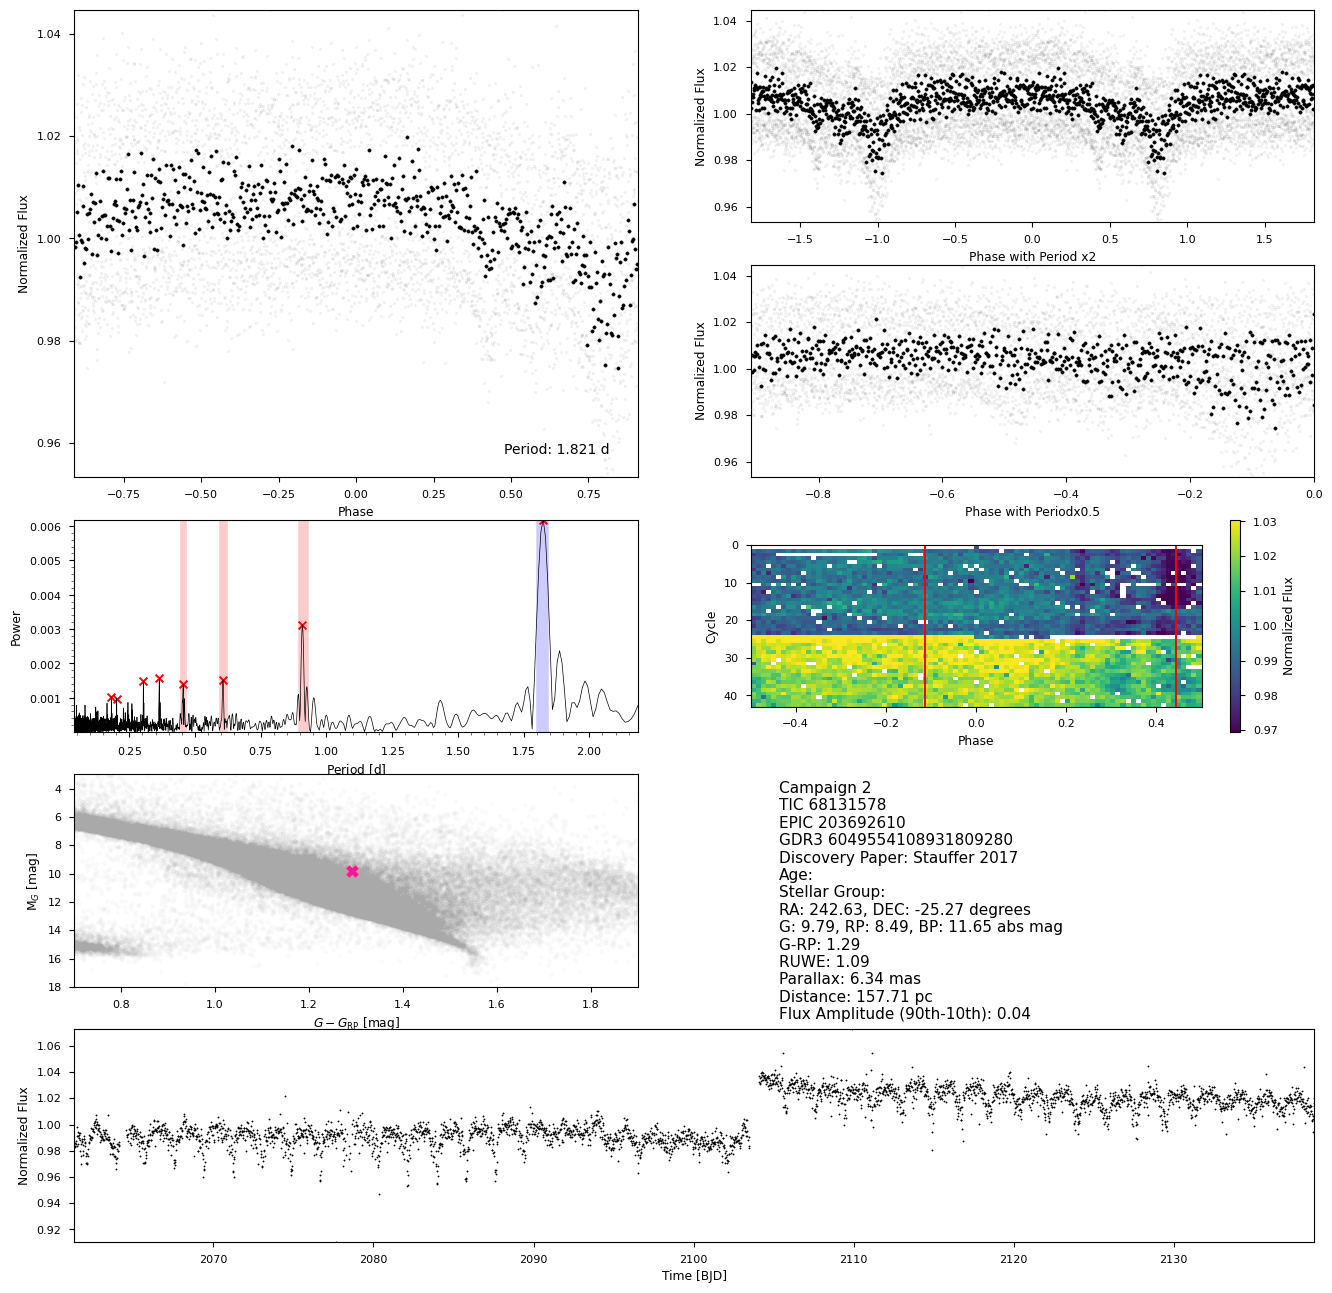

In [37]:
plt.close('all')
multiplot2(mylc6, 'EPIC-203692610-2-K2SFF-1800', gaiatable,period=u.Quantity(1.821,u.d))
plt.show()
#plt.savefig('EPIC-203692610-2-K2SFF-1800.png')

In [38]:
# def subgraph_CMD(infostring,gaiatable,ax=None):
#     #gaiatable must be a dataframe. load it in the multiplot fn
#     fig = None
    
#     parts=infostring.split("-")
#     id_type=parts[0]
#     starid=float(parts[1])
#     secorcamp=parts[2]
#     author=parts[3]
#     exptime=parts[4]
    
#     if ax == None:
#         fig, ax = plt.subplots()
        
#     ax.scatter(gaiatable.abs_g_rp,gaiatable.g_absmag,marker='.',c='darkgray',alpha=0.05)
#     if id_type=='TIC':
#         ax.scatter(gaiatable[gaiatable.TIC==starid].abs_g_rp,gaiatable[gaiatable.TIC==starid].g_absmag,marker='X',s=75,c='deeppink')
#     elif id_type=='EPIC':
#         ax.scatter(gaiatable[gaiatable.epic_id==starid].abs_g_rp,gaiatable[gaiatable.epic_id==starid].g_absmag,marker='X',s=75,c='deeppink')
#     ax.invert_yaxis()
#     ax.set_xlim(0.7,1.9)
#     ax.set_ylim(18,3)
#     ax.set_ylabel(r'M$_G$ [mag]')
#     ax.set_xlabel(r'$G-G_{\text{RP}}$ [mag]')

#     if fig != None:
#         return fig

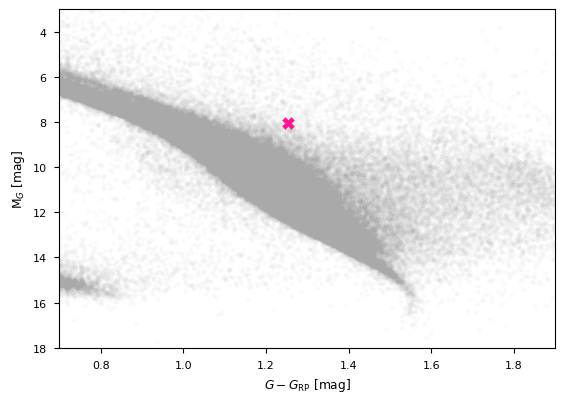

In [39]:
subgraph_CMD('TIC-59129133-43-SPOC-120',gaiatable)